# Часть 4. Обучение нейронных сетей

Датасет: https://www.kaggle.com/competitions/digit-recognizer/data

Для представленного датасета необходимо:

1. Решить задачу многоклассовой классификации с помощью многослойной нейронной сети, состоящей из полносвязных слоев.

2. Вычислить градиент целевой функции по обучаемым параметрам нейронной
сети, сравнить полученные значения со значениями, вычисленными с помощью библиотечных функций

3. Определить параметры нейронной сети, при которых точность классификации максимальна

Задание выполнил: Никита Пархоменко

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import cv2

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gc

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Task: **Multiclass Classification**

Input: **28x28 grayscale images**

Target: Label (0-9)

## Решение

При решении воспользуемся библиотекой Torch.

In [ ]:
df = pd.read_csv('gdrive/My Drive/ml_task_hse/task4_data/train.csv', sep=',')
df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
labels = sorted(df.label.unique())
label_counts = df.label.value_counts().sort_index()

print(f'Classes: {labels}')
print(f'Images per class:\n{label_counts}')

Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Images per class:
0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64


### Подготовим данные

In [ ]:
# Data processing & dataloaders
def get_dataloaders(df, batch_size=16, verbose=False):
  X, y = df.drop('label', axis=1), df['label']
  X = np.array(X)
  X = X.astype('float32')
  X = X / 255.0
  X = cv2.cvtColor(X, cv2.COLOR_GRAY2RGB)
  X = X.reshape(-1, 28, 28, 3)

  # Example of image
  if verbose:
    print(f"\nImage with label {y[7]}")
    plt.imshow(X[7])

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

  # Create tensors and dataloaders
  X_train =  torch.from_numpy(X_train).float()
  y_train =  torch.from_numpy(y_train.values)
  train_tensor = TensorDataset(X_train, y_train)

  X_val =  torch.from_numpy(X_val).float()
  y_val =  torch.from_numpy(y_val.values)
  val_tensor = TensorDataset(X_val, y_val)

  train_loader = DataLoader(train_tensor, batch_size=batch_size, num_workers=2, shuffle=True)
  val_loader = DataLoader(val_tensor, batch_size=batch_size, num_workers=2, shuffle=False)

  return train_loader, val_loader

### Подготовим нейросетевую модель (MLP, Dense Neural Network)

In [ ]:
# NN class
class DigitRecognizer(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.dense_module = nn.Sequential(
      nn.Linear(28*28*3, 512),
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU()
      )
    self.classification_module = nn.Linear(256, 10)

  def forward(self, x):
    x = self.flatten(x)
    x = self.dense_module(x)
    output = self.classification_module(x)
    return output

In [ ]:
def train_model(data_loader, model, loss_fn, optimizer, device, verbose=False):
  model.train()
  size = len(data_loader.dataset)

  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    pred = model(X)
    loss = loss_fn(pred, y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 100 == 0:
      loss, current  = loss, (batch + 1)*len(X)
      if verbose:
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
  return model

def val_model(data_loader, model, loss_fn, device, verbose=False):
  model.eval()
  size = len(data_loader.dataset)
  num_batches = len(data_loader)
  val_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      val_loss += loss_fn(pred, y)
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  val_loss /= num_batches
  accuracy = correct / size
  if verbose:
    print(f"Validation\n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {val_loss:>8f} \n")
  return accuracy, val_loss


Image with label 3


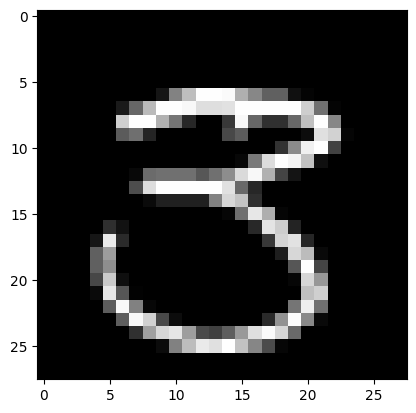

In [ ]:
train_loader, val_loader = get_dataloaders(df, batch_size=16, verbose=True)

In [ ]:
model = DigitRecognizer()
print(model)

DigitRecognizer(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_module): Sequential(
    (0): Linear(in_features=2352, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (classification_module): Linear(in_features=256, out_features=10, bias=True)
)


### Проведем эксперимент

In [ ]:
def experiment_wrapper(df, batch_size=16, learning_rate=1e-3, epochs=10, verbose=True):
  print(f"Experiment: lr={learning_rate}, batch_size={batch_size}, {epochs} epochs")

  device = ('cuda' if torch.cuda.is_available() else 'cpu')
  print(f"Using {device} device")

  train_loader, val_loader = get_dataloaders(df, batch_size=batch_size)

  model = DigitRecognizer().to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  best_model = None
  best_accuracy = 0.0
  best_loss = np.inf
  best_epoch = 1

  for epoch in range(epochs):
    if verbose:
      print(f"Epoch {epoch+1}\n-------------------------------")
    model = train_model(train_loader, model, loss_fn, optimizer, device)
    accuracy, val_loss = val_model(val_loader, model, loss_fn, device, verbose)
    if accuracy > best_accuracy:
      best_model = model
      best_accuracy = accuracy
      best_loss = val_loss
      best_epoch = epoch + 1
  print(f"Best model from epoch {best_epoch}")
  print(f"Best model val accuracy: {(100*best_accuracy):>0.1f}%")
  print(f"Best model val loss: {best_loss:>8f}")
  print("\n")
  return best_model

In [ ]:
model = experiment_wrapper(df, batch_size=16, learning_rate=1e-3, epochs=10, verbose=True)

Experiment: lr=0.001, batch_size=16, 10 epochs
Using cuda device
Epoch 1
-------------------------------
Validation
 Accuracy: 96.0%, Avg loss: 0.126654 

Epoch 2
-------------------------------
Validation
 Accuracy: 96.2%, Avg loss: 0.122080 

Epoch 3
-------------------------------
Validation
 Accuracy: 95.8%, Avg loss: 0.155665 

Epoch 4
-------------------------------
Validation
 Accuracy: 97.1%, Avg loss: 0.097300 

Epoch 5
-------------------------------
Validation
 Accuracy: 96.6%, Avg loss: 0.124101 

Epoch 6
-------------------------------
Validation
 Accuracy: 96.9%, Avg loss: 0.135605 

Epoch 7
-------------------------------
Validation
 Accuracy: 97.3%, Avg loss: 0.133295 

Epoch 8
-------------------------------
Validation
 Accuracy: 97.4%, Avg loss: 0.125888 

Epoch 9
-------------------------------
Validation
 Accuracy: 97.1%, Avg loss: 0.157616 

Epoch 10
-------------------------------
Validation
 Accuracy: 96.9%, Avg loss: 0.195714 

Best model from epoch 8
Best model

Задача решена. Качество классификации высокое - порядка 97.4% accuracy.

Попробуем теперь перебирать гиперпараметры для того, чтобы добиться максимально возможного качества (с точки зрения accuracy - по заданию).

### Подбор гиперпараметров

In [ ]:
import itertools

param_grid = {'batch_size': [8, 16, 32], 'learning_rate': [1e-2, 1e-3, 1e-4, 1e-5]}

keys, values = zip(*param_grid.items())
param_combos = [dict(zip(keys, v)) for v in itertools.product(*values)]

# подбор гиперпараметров
for elem in param_combos:
  batch_size = elem['batch_size']
  learning_rate = elem['learning_rate']
  model = experiment_wrapper(df, batch_size=batch_size, learning_rate=learning_rate, epochs=10, verbose=False)
  _ = gc.collect()

Experiment: lr=0.01, batch_size=8, 10 epochs
Using cuda device
Best model from epoch 5
Best model val accuracy: 91.5%
Best model val loss: 0.427945


Experiment: lr=0.001, batch_size=8, 10 epochs
Using cuda device
Best model from epoch 10
Best model val accuracy: 97.3%
Best model val loss: 0.198529


Experiment: lr=0.0001, batch_size=8, 10 epochs
Using cuda device
Best model from epoch 10
Best model val accuracy: 97.8%
Best model val loss: 0.096401


Experiment: lr=1e-05, batch_size=8, 10 epochs
Using cuda device
Best model from epoch 10
Best model val accuracy: 94.8%
Best model val loss: 0.181039


Experiment: lr=0.01, batch_size=16, 10 epochs
Using cuda device
Best model from epoch 8
Best model val accuracy: 94.9%
Best model val loss: 0.275287


Experiment: lr=0.001, batch_size=16, 10 epochs
Using cuda device
Best model from epoch 10
Best model val accuracy: 97.3%
Best model val loss: 0.183396


Experiment: lr=0.0001, batch_size=16, 10 epochs
Using cuda device
Best model from epoch 7

Таким образом, наилучшей конфигурацией с точки зрения accuracy оказалась:

Experiment: lr=0.0001, batch_size=8, 10 epochs

При этом, accuracy на валидационной выборке составила 97.8%.

Запустим этот эксперимент еще раз (но уже с 15 эпохами) и зафиксируем модель.

In [ ]:
model = experiment_wrapper(df, batch_size=8, learning_rate=1e-4, epochs=15, verbose=True)

Experiment: lr=0.0001, batch_size=8, 15 epochs
Using cuda device
Epoch 1
-------------------------------
Validation
 Accuracy: 94.3%, Avg loss: 0.200825 

Epoch 2
-------------------------------
Validation
 Accuracy: 96.0%, Avg loss: 0.136469 

Epoch 3
-------------------------------
Validation
 Accuracy: 96.8%, Avg loss: 0.102768 

Epoch 4
-------------------------------
Validation
 Accuracy: 97.0%, Avg loss: 0.093861 

Epoch 5
-------------------------------
Validation
 Accuracy: 97.3%, Avg loss: 0.091612 

Epoch 6
-------------------------------
Validation
 Accuracy: 97.5%, Avg loss: 0.086031 

Epoch 7
-------------------------------
Validation
 Accuracy: 97.1%, Avg loss: 0.101485 

Epoch 8
-------------------------------
Validation
 Accuracy: 97.5%, Avg loss: 0.092690 

Epoch 9
-------------------------------
Validation
 Accuracy: 97.5%, Avg loss: 0.093044 

Epoch 10
-------------------------------
Validation
 Accuracy: 97.8%, Avg loss: 0.097937 

Epoch 11
-------------------------

Проверим адекватность модели на каком-нибудь наборе картинок.

In [ ]:
model

DigitRecognizer(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_module): Sequential(
    (0): Linear(in_features=2352, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (classification_module): Linear(in_features=256, out_features=10, bias=True)
)


Image prediction example
Prediction: 8


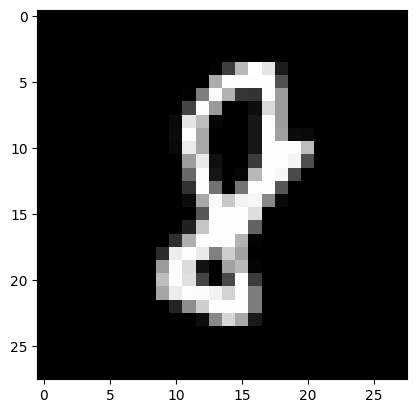

Prediction: 1


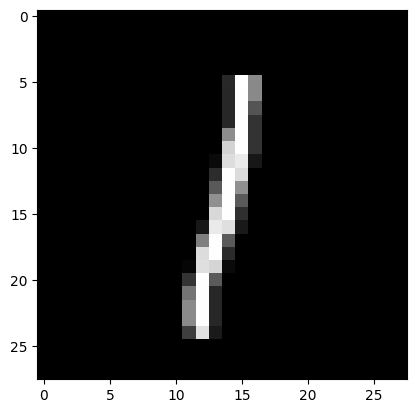

Prediction: 9


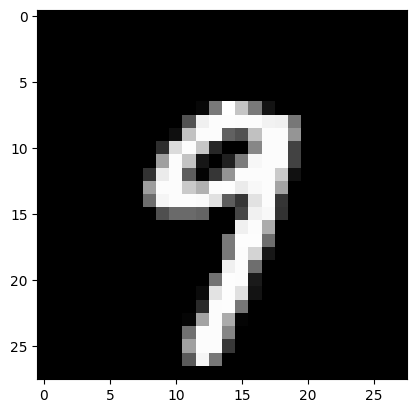

Prediction: 9


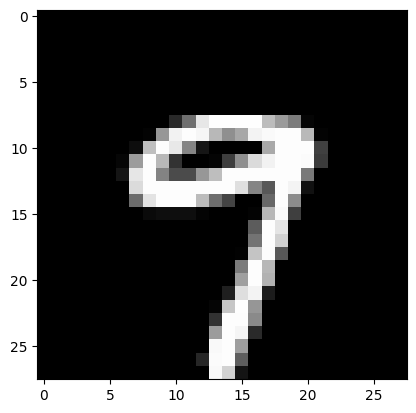

Prediction: 8


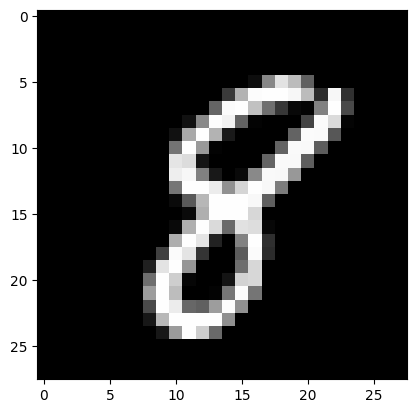

In [ ]:
# Prediction example

X_tensors = []
y_preds = []

device = ('cuda' if torch.cuda.is_available() else 'cpu')
train_loader, val_loader = get_dataloaders(df, batch_size=batch_size)
model.eval()
with torch.no_grad():
    for X, y in val_loader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      X = X.to('cpu')
      X_tensors.append(X)
      pred = pred.to('cpu')
      pred_probab = nn.Softmax(dim=1)(pred)
      y_pred = pred_probab.argmax(1)
      y_preds.append(y_pred)

X_tensors = X_tensors[0]
y_preds = y_preds[0]

print(f"\nImage prediction example")
for i in range(5):
  print(f"Prediction: {y_preds[i]}")
  test_img_plot = plt.imshow(X_tensors[i])
  plt.show()